<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Figure-2.1" data-toc-modified-id="Figure-2.1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figure 2.1</a></span></li><li><span><a href="#Figure-2.2" data-toc-modified-id="Figure-2.2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 2.2</a></span></li><li><span><a href="#Figure-2.3" data-toc-modified-id="Figure-2.3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Figure 2.3</a></span></li></ul></div>

In [1]:
## Analyzing Neural Time Series Data
# Python code for Chapter 2
# Yujin Goto (MATLAB original code: Mike X Cohen)
# 
# This code accompanies the book, titled "Analyzing Neural Time Series Data" 
# (MIT Press). Using the code without following the book may lead to confusion, 
# incorrect data analyses, and misinterpretations of results. 
# Mike X Cohen and Yujin Goto assumes no responsibility for inappropriate or incorrect use of this code. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.fft import fft, ifft
from scipy.signal import firls, filtfilt

In [3]:
eeg_data = loadmat('./NeuralData/sampleEEGdata.mat')
EEG = eeg_data['EEG'][0, 0]  # Adjust indexing based on the structure of the .mat file

## Figure 2.1

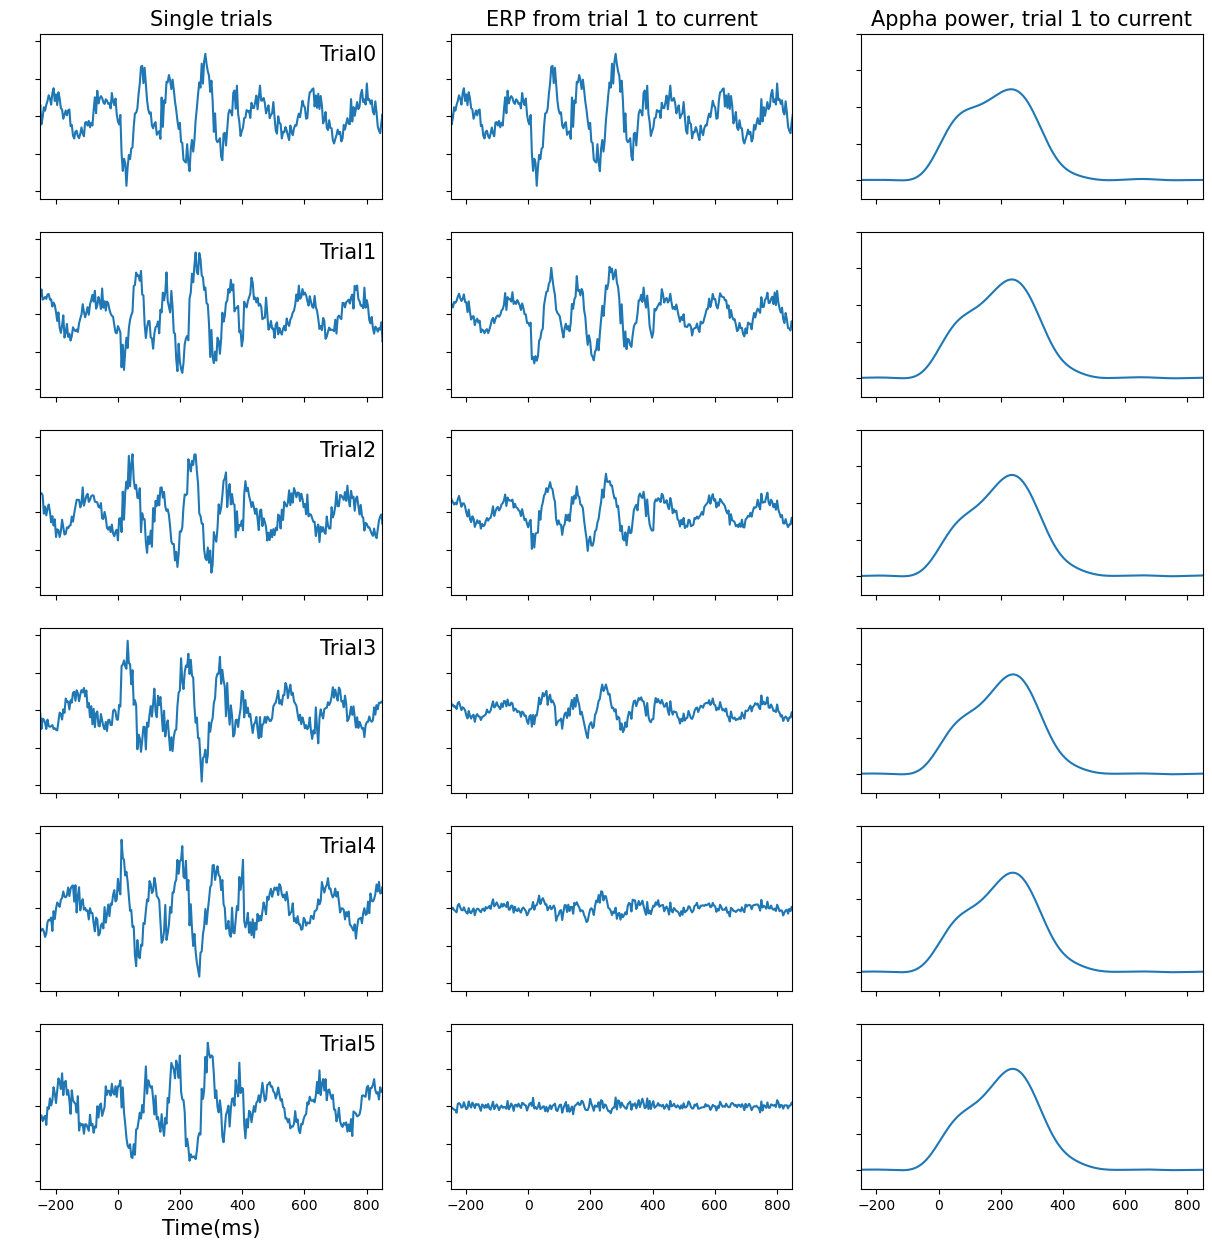

In [4]:
nTrials = 6

# Initialize the data array
data = np.zeros((nTrials, EEG['pnts'][0,0]))

# Wavelet parameters
wavetime = np.arange(-1, 1 + 1/EEG['srate'][0,0], 1/EEG['srate'][0,0])
n_conv = len(wavetime) + EEG['pnts'][0,0] - 1
waveletfft = fft(np.exp(2*1j*np.pi*10*wavetime) * np.exp(-wavetime**2 / (2 * (5 / (2*np.pi*10))**2)) / 10, n_conv)
data10hz = np.zeros((nTrials, EEG['pnts'][0,0]))

plt.figure(figsize=(15,15))
# Generate and plot data
for triali in range(nTrials):
    
    # Create single trial "ERP"
    data[triali, :] = 0.5 * np.sin(2*np.pi*6*EEG['times'][0]/1000 + 2*np.pi*triali/nTrials - np.pi) + np.random.randn(EEG['pnts'][0,0])/6
    # Add non-phase-locked stimulus potential
    idx_range = np.arange(259, 360)  # Adjusted index for Python
    data[triali, idx_range] += np.sin(2*np.pi*10*EEG['times'][0, idx_range]/1000 + 2*np.pi*triali/nTrials - np.pi) + np.random.randn(len(idx_range))/5
    
    # Plot data from this trial
    plt.subplot(nTrials, 3, triali * 3 + 1)
    plt.plot(EEG['times'][0], data[triali, :])
    plt.xlim([-250, 850])
    plt.xticks(color='None')
    plt.ylim([-2.2, 2.2])
    plt.yticks(color='None')
    legend = f"Trial{triali}"
    plt.text(650,1.5, legend, fontsize=15)
    if triali == 0:
        plt.title('Single trials', fontsize=15)
    elif triali == nTrials-1:
        plt.xticks(color='black')
        plt.xlabel('Time(ms)', fontsize=15)

    # Plot ERP from trial 1 to current
    plt.subplot(nTrials, 3, triali * 3 + 2)
    plt.plot(EEG['times'][0], np.mean(data[:triali+1, :], axis=0))
    plt.xlim([-250, 850])
    plt.xticks(color='None')
    plt.ylim([-2.2, 2.2])
    plt.yticks(color='None')
    if triali == 0:
        plt.title('ERP from trial 1 to current', fontsize=15)
    elif triali == nTrials-1:
        plt.xticks(color='black')

    # Convolve with 10 Hz wavelet
    convolution_result_fft = ifft(waveletfft * fft(data[triali, :], n_conv)) * np.sqrt(5/(2*np.pi*10))
    half_of_wavelet_size = int(np.floor(len(wavetime) / 2))
    convolution_result_fft = convolution_result_fft[half_of_wavelet_size:-half_of_wavelet_size]

    data10hz[triali, :] = np.abs(convolution_result_fft)**2

    # Plot 10 Hz power
    plt.subplot(nTrials, 3, triali * 3 + 3)
    plt.plot(EEG['times'][0], np.mean(data10hz[:triali+1, :], axis=0))
    plt.xlim([-250, 850])
    plt.xticks(color='None')
    plt.ylim([-.1, .8])
    plt.yticks(color='None')
    if triali == 0:
        plt.title('Appha power, trial 1 to current', fontsize=15)
    elif triali == nTrials-1:
        plt.xticks(color='black')

plt.show()

## Figure 2.2


In [5]:
#(This code involves performing convolution with a complex Morlet wavelet,
#which you will learn about in Chapters 10-13.)

In [6]:
# Parameters
srate = 1000
time = np.arange(0, 10, 1/srate)
DCoffset = -0.5

# Create multi-frequency signal
a = np.sin(2*np.pi*10*time)  # High frequency part
b = 0.1*np.sin(2*np.pi*0.3*time) + DCoffset  # Low frequency part
data = a * b  # Combined signal
data += (2*np.sin(2*np.pi*3*time) * np.sin(2*np.pi*0.07*time)*0.1 + DCoffset)

# Morlet wavelet convolution
num_frex = 40
min_freq = 2
max_freq = 20

Ldata = len(data)
Ltapr = len(data)
Lconv1 = Ldata + Ltapr -1
Lconv = int(2**np.ceil(np.log2(Lconv1)))
frex = np.logspace(np.log10(min_freq), np.log10(max_freq), num_frex)

# Initialize time-frequency representation
tf = np.zeros((num_frex, len(data)))
datspctra = fft(data, Lconv)

s = 4 / (2 * np.pi * frex)
t = np.arange(-Ldata/2, Ldata/2) / srate
        
for fi in range(len(frex)):
    wavelet = np.exp(2*1j*np.pi*frex[fi]*t) * np.exp(-t**2 / (2 * s[fi]**2))
    m = ifft(datspctra * fft(wavelet, Lconv), Lconv)
    m = m[:Lconv1]
    m = m[int(np.floor((Ltapr-1)/2)):-int(np.ceil((Ltapr-1)/2))]
    tf[fi, :] = np.abs(m)**2

In [7]:
#int(pow(np.log2(2**np.ceil(np.log2(Lconv1))),2))
2**np.ceil(np.log2(Ldata + Ldata - 1)).astype(int)

32768

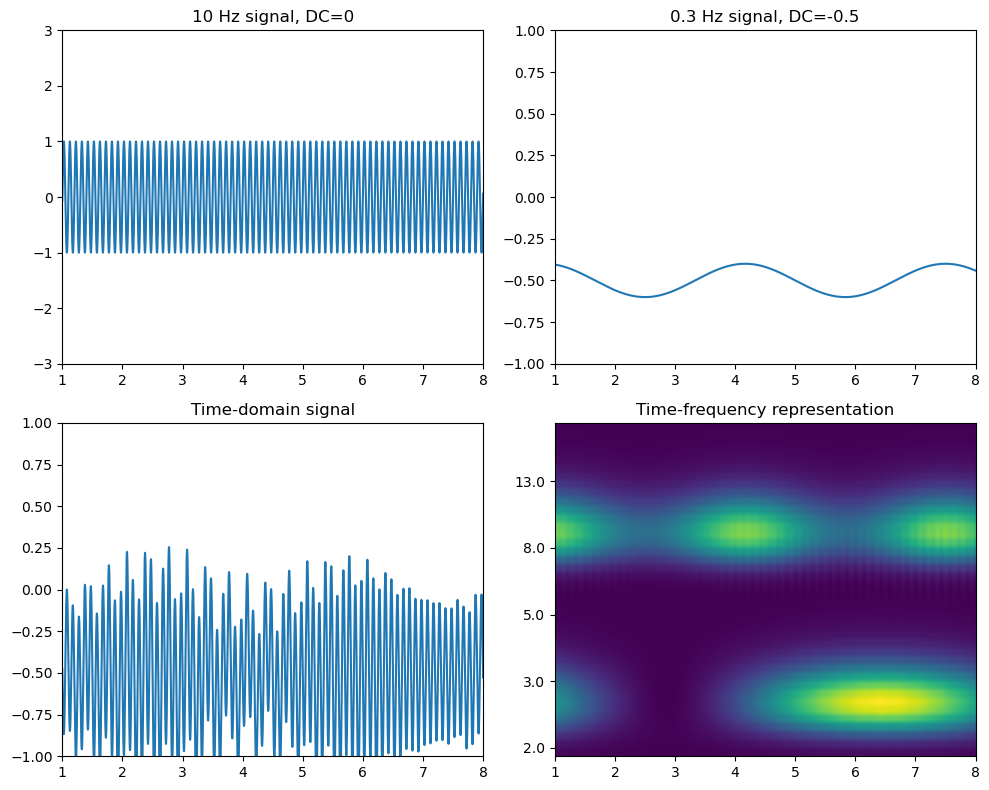

In [8]:
# Plotting
plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
plt.plot(a)
plt.xlim([1000, 8000])
plt.ylim([-3, 3])
plt.xticks(np.arange(1000, 8001, 1000), np.arange(1, 9))
plt.title('10 Hz signal, DC=0')

plt.subplot(2, 2, 2)
plt.plot(b)
plt.xlim([1000, 8000])
plt.ylim([-1, 1])
plt.xticks(np.arange(1000, 8001, 1000), np.arange(1, 9))
plt.title('0.3 Hz signal, DC={}'.format(DCoffset))

plt.subplot(2, 2, 3)
plt.plot(data)
plt.xlim([1000, 8000])
plt.ylim([-1, 1])
plt.xticks(np.arange(1000, 8001, 1000), np.arange(1, 9))
plt.title('Time-domain signal')

plt.subplot(2, 2, 4)
plt.imshow(tf, aspect='auto', extent=[len(data), 0, 0, num_frex], origin='lower')
#plt.colorbar()
plt.xlim([1000, 8000])
plt.yticks(np.arange(1, num_frex+1, 8), np.round(frex[::8]))
plt.xticks(np.arange(1000, 8001, 1000), np.arange(1, 9))
plt.title('Time-frequency representation')

plt.tight_layout()
plt.show()

## Figure 2.3

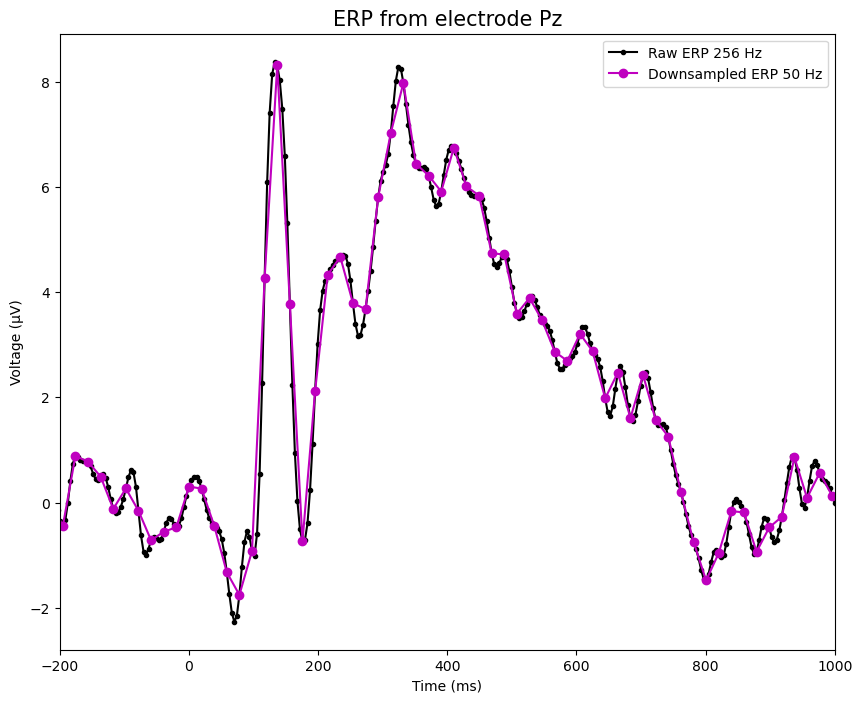

In [9]:
# Select channel
chan2plot = 'Pz'
eeg_chan_labels=EEG["chanlocs"]["labels"]
channel_index = np.where(eeg_chan_labels  == chan2plot)[1] #specify index (channel number) of label

# Compute ERP
erp = np.mean(EEG['data'][channel_index, :, :], axis=2)

# Low-pass filter parameters
nyquist = int(EEG['srate']) / 2
filter_cutoff = 40  # Hz
trans_width = 0.1  # Transition width in fraction of 1

# Design filter
ffrequencies = np.array([0, filter_cutoff, filter_cutoff * (1 + trans_width), nyquist]) / nyquist
idealresponse = [1, 1, 0, 0]
filterweights = firls(101, ffrequencies, idealresponse)

# Apply filter
filtered_erp = filtfilt(filterweights, 1, erp)

# Plotting
plt.figure(figsize=(10,8))

# Plot ERP
plt.plot(EEG['times'][0], filtered_erp[0], 'k.-', label='Raw ERP 256 Hz')

# Downsample and plot
downsample_factor = 5
plt.plot(EEG['times'][0,1:-1:5], filtered_erp[0,1:-1:5], 'mo-', label='Downsampled ERP 50 Hz')

plt.xlim([-200, 1000])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (μV)')
plt.title(f'ERP from electrode {chan2plot}', fontsize=15)
plt.legend()
plt.show()